In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import yfinance as yf
from typing import Tuple

#### VaR First Steps

Historical VaR (VaR = - Xth percentile of the historical distribution of portfolio returns)

In [2]:
def historical_var(returns: pd.DataFrame, weights : np.array, confidence_level: float) -> float:
    return np.percentile(returns @ weights, 100 - (confidence_level * 100))

Conditional VaR (CVaR = -(1/α) × ∫α₀ VaR(x)dx, where CVaR is the Conditional VaR, VaR is the VaR at confidence level α, and α₀ is the VaR confidence level)

In [3]:
def historical_Cvar(returns: pd.DataFrame, weights : np.array, confidence_level: float) -> float:
    portfolio_returns = returns @ weights
    belowVaR = portfolio_returns <= historical_var(returns, weights, confidence_level)
    return portfolio_returns[belowVaR].mean()

Test Portfolio

In [4]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']
weights = np.array([0.25, 0.25, 0.25, 0.25])

data = yf.download(tickers, start='2022-01-01', end='2023-12-31')['Adj Close'] # 1 year

daily_returns = data.pct_change().dropna()

[*********************100%***********************]  4 of 4 completed


In [5]:
hist_var = historical_var(daily_returns, weights, 0.95)
hist_var

-0.035500328125188385

In [6]:
hist_var * np.sqrt(10)

-0.11226189455893044

In [7]:
hist_cvar = historical_Cvar(daily_returns, weights, 0.95)
hist_cvar

-0.04312153207493769

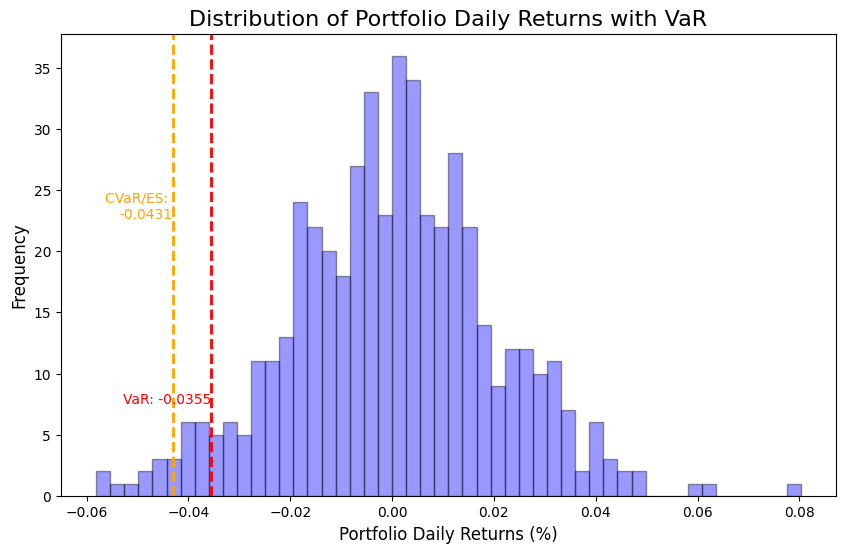

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(daily_returns @ weights, bins=50, color='blue', alpha=0.4, edgecolor='black')
plt.axvline(hist_var, color='red', linestyle='--', linewidth=2, label=f'VaR (5%): {hist_var:.4f}')
plt.text(hist_var, plt.gca().get_ylim()[1] * .2, f'VaR: {hist_var:.4f}', color='red', fontsize=10, ha='right')

plt.axvline(hist_cvar, color='orange', linestyle='--', linewidth=2, label=f'CVaR: {hist_cvar:.4f}')
plt.text(hist_cvar, plt.gca().get_ylim()[1] * 0.6, f'CVaR/ES: \n{hist_cvar:.4f}', color='orange', fontsize=10, ha='right')

plt.title("Distribution of Portfolio Daily Returns with VaR", fontsize=16)
plt.xlabel("Portfolio Daily Returns (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

#### Parametric VaR

In [9]:
def portfolio_performance(weights: np.ndarray, 
                          mean_returns: np.ndarray, 
                          cov: np.ndarray, 
                          Time: int) -> Tuple[float, float]:
    mean_w = np.sum(mean_returns*weights)*Time
    std_w = np.sqrt(weights.T @ cov @ weights) * np.sqrt(Time)
    return mean_w, std_w

In [10]:
def parametric_var(mean: np.ndarray, 
                    volatility: np.ndarray, 
                    confidence_level: float,
                    ppf: callable = ss.norm.ppf,) -> float:

    z_alpha = ppf(confidence_level) # don't forget preprocessing std/volatility according to dist

    return z_alpha * volatility - mean

In [11]:
mean_returns = daily_returns.mean()
cov_returns =  daily_returns.cov()
Time = 10

mean_w, std_w = portfolio_performance(weights, mean_returns,cov_returns, Time)

In [12]:
par_var = parametric_var(mean_w, std_w, 0.95)
par_var

0.10410261984984868

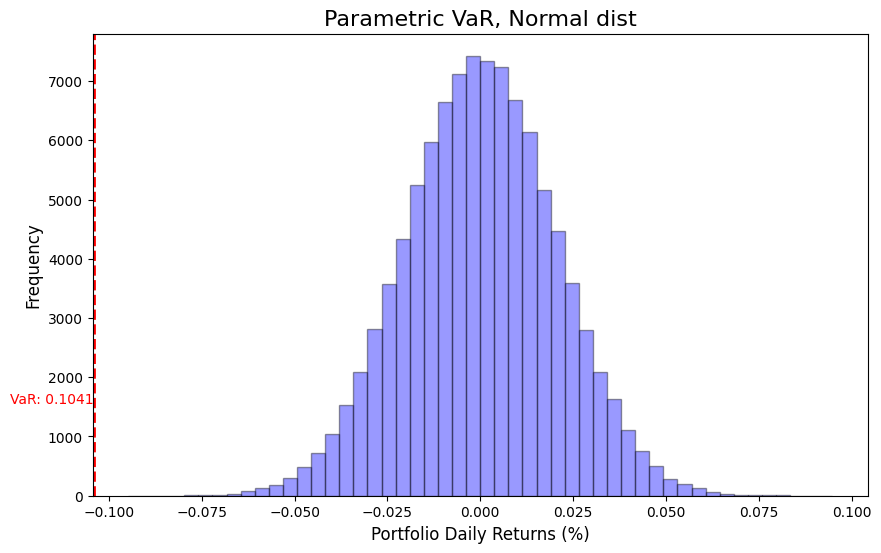

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(np.random.normal(loc=np.mean(daily_returns @ weights), scale=np.std(daily_returns @ weights), size=100000), bins=50, color='blue', alpha=0.4, edgecolor='black')
plt.axvline(-par_var, color='red', linestyle='--', linewidth=2, label=f'VaR (5%): {par_var:.4f}')
plt.text(-par_var, plt.gca().get_ylim()[1] * .2, f'VaR: {par_var:.4f}', color='red', fontsize=10, ha='right')

# plt.axvline(hist_cvar, color='orange', linestyle='--', linewidth=2, label=f'CVaR: {hist_cvar:.4f}')
# plt.text(hist_cvar, plt.gca().get_ylim()[1] * 0.6, f'CVaR/ES: \n{hist_cvar:.4f}', color='orange', fontsize=10, ha='right')

plt.title("Parametric VaR, Normal dist", fontsize=16)
plt.xlabel("Portfolio Daily Returns (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

#### Monte Carlo Portfolio Sim

In [14]:
# Monte Carlo Method
num_trails = 100000 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=mean_returns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, num_trails), fill_value=0.0)

initialPortfolio = 10000

for m in range (num_trails):
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(cov_returns)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

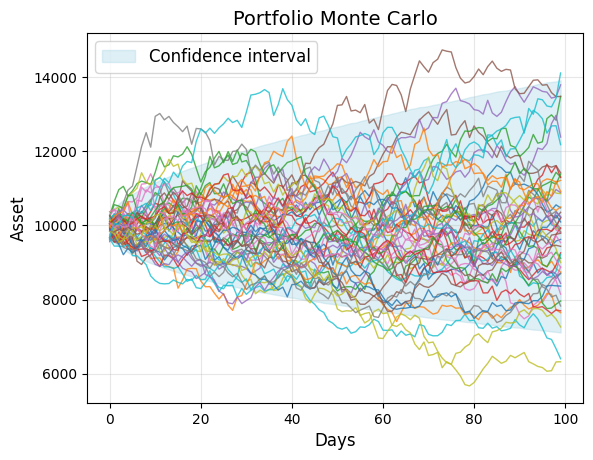

In [15]:
mean_simulation = portfolio_sims.mean(axis=1)
percentile_5 = np.percentile(portfolio_sims, 5, axis=1)
percentile_95 = np.percentile(portfolio_sims, 95, axis=1)

plt.fill_between(range(T), percentile_5, percentile_95, color="lightblue", alpha=0.4, label = "Confidence interval")

for i in range(50): 
    plt.plot(portfolio_sims[:, i], linewidth=1, alpha=0.8)

plt.title("Portfolio Monte Carlo", fontsize=14)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Asset", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

#### Outputs

In [16]:
portfolio_values_day_10 = portfolio_sims[9, :]

ten_day_returns = (portfolio_values_day_10 / initialPortfolio - 1)

#10-day VaR
ten_day_var = np.percentile(ten_day_returns, 5)

absolute_var = initialPortfolio * ten_day_var

print(f"10-дневный VaR: {ten_day_var} или {absolute_var}")

10-дневный VaR: -0.10131587020909534 или -1013.1587020909534


In [17]:
print(f"10-day HistVaR: {hist_var*np.sqrt(10)} or {hist_var*initialPortfolio*np.sqrt(10)}")

10-day HistVaR: -0.11226189455893044 or -1122.6189455893043


In [18]:
print(f"10-day ParamVaR: {par_var} or {par_var*initialPortfolio}")

10-day ParamVaR: 0.10410261984984868 or 1041.0261984984868


#### Play with interesting bibl

In [19]:
from fitter import Fitter

In [20]:
simulated_data = ss.norm.rvs(loc=10, scale = 10.5, size=10000)


f = Fitter(simulated_data)
f.fit()

2025-01-27 16:35:14.177 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2025-01-27 16:35:14.209 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=0.227613)
2025-01-27 16:35:14.245 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.002799)
2025-01-27 16:35:14.283 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=0.007502)
2025-01-27 16:35:14.299 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted bradford distribution with error=0.021248)
2025-01-27 16:35:14.321 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted argus distribution with error=0.012413)
2025-01-27 16:35:14.331 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=0.000362)
2025-01-27 16:35:14.334 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fi

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
levy_stable,0.00023,1090.974038,1119.815399,inf,0.006772,0.746003
crystalball,0.00023,1092.476389,1121.317751,inf,0.006418,0.802125
truncnorm,0.00023,1092.476392,1121.317753,inf,0.006418,0.802125
norm,0.00023,1088.476392,1102.897072,inf,0.006418,0.802125
exponnorm,0.00023,1090.476705,1112.107726,inf,0.006417,0.802156


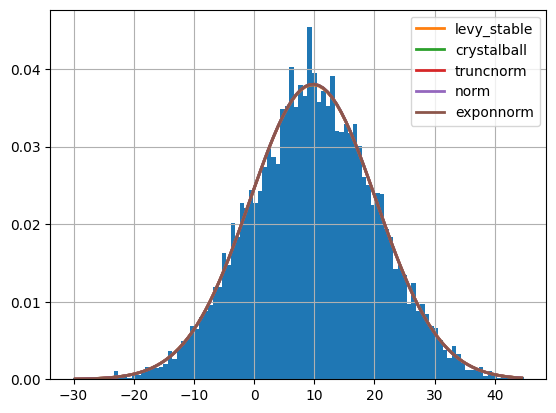

In [21]:
f.summary()

In [22]:
f.get_best()

{'levy_stable': {'alpha': 2.0,
  'beta': 1.0,
  'loc': 9.799527168846076,
  'scale': 7.4326318044166015}}

((array([-3.81060943, -3.58545756, -3.46184782, ...,  3.46184782,
          3.58545756,  3.81060943]),
  array([-30.08665019, -28.72538875, -26.4856764 , ...,  43.68352587,
          44.33263677,  44.84003328])),
 (10.490358987977181, 9.799492774059786, 0.9999240027013122))

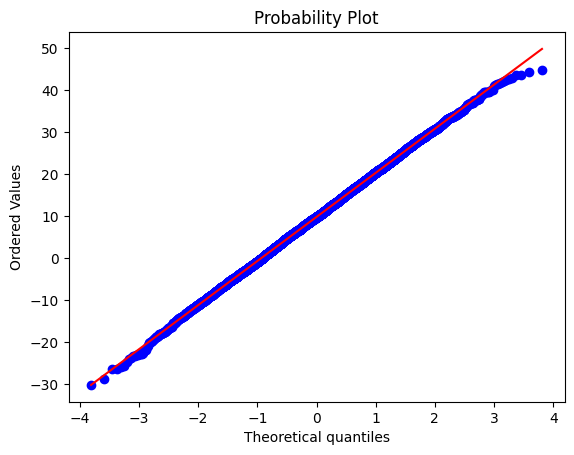

In [23]:
ss.probplot(simulated_data, dist="norm", plot=plt)

In [24]:
f = Fitter(daily_returns)
f.fit()

2025-01-27 16:36:14.329 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2025-01-27 16:36:14.369 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted arcsine distribution with error=5826.179475)
2025-01-27 16:36:14.377 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=468.01426)
2025-01-27 16:36:14.379 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted argus distribution with error=3251.385606)
2025-01-27 16:36:14.384 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted bradford distribution with error=4003.412164)
2025-01-27 16:36:14.401 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=254.299777)
2025-01-27 16:36:14.414 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi distribution with error=4801.545659)
2025-01-27 16:36:14.415 | INFO     | fitter.fitter:_fit_single_distri

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
genhyperbolic,90.511310,-9.976752,18.027760,inf,0.010162,0.984686
norminvgauss,90.632615,-13.056848,9.346761,inf,0.008978,0.996634
johnsonsu,91.989589,-10.161880,12.241730,inf,0.009201,0.995301
dgamma,93.922037,-5.956707,10.846000,inf,0.014607,0.781226
dweibull,94.096944,-4.230756,12.571951,inf,0.015410,0.723118


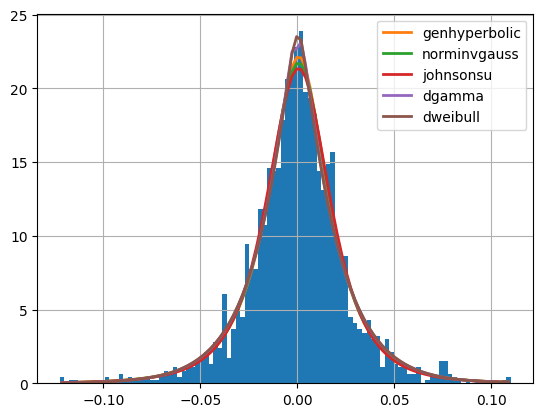

In [25]:
f.summary()

In [26]:
f.get_best()

{'genhyperbolic': {'p': 0.035928364409371694,
  'a': 0.6880750344495623,
  'b': -0.016443812234690814,
  'loc': 0.0008223474046018082,
  'scale': 0.01653715862648858}}

#### Real Archegos Stock Portfolio

In [27]:
ticker = yf.Ticker("PARA")

shares_outstanding = ticker.info.get("sharesOutstanding")

shares_outstanding

626273024

In [28]:
ticker.info

{'address1': '1515 Broadway',
 'city': 'New York',
 'state': 'NY',
 'zip': '10036',
 'country': 'United States',
 'phone': '212 258 6000',
 'website': 'https://www.paramount.com',
 'industry': 'Entertainment',
 'industryKey': 'entertainment',
 'industryDisp': 'Entertainment',
 'sector': 'Communication Services',
 'sectorKey': 'communication-services',
 'sectorDisp': 'Communication Services',
 'longBusinessSummary': 'Paramount Global operates as a media, streaming, and entertainment company worldwide. It operates through TV Media, Direct-to-Consumer, and Filmed Entertainment segments. The TV Media segment operates CBS Television Network, a domestic broadcast television network; CBS Stations, a television station; and international free-to-air networks comprising Network 10, Channel 5, Telefe, and Chilevisión; domestic premium and basic cable networks, such as Paramount+ with Showtime, MTV, Comedy Central, Paramount Network, The Smithsonian Channel, Nickelodeon, BET Media Group, and CBS 

In [29]:
historical_data = yf.download("FTCHQ", start="2020-02-03", end="2020-02-04") # FTCH + Q added to stock of companies in bankruptcy (Chapter 11 in the U.S.)
print(historical_data)

[*********************100%***********************]  1 of 1 completed

Price      Adj Close  Close   High    Low   Open   Volume
Ticker         FTCHQ  FTCHQ  FTCHQ  FTCHQ  FTCHQ    FTCHQ
Date                                                     
2020-02-03     12.09  12.09  12.24  11.85  12.15  2261109


In [80]:
tickers = ['PARA',
            "WBD",
            "GOTU",
            "IQ",
            "TME",
            "VIPS",
            "BIDU",
            "FTCHQ", 
            "TCBI"
            ]

results = []

for ticker_symbol in tickers:
    historical_data = yf.download(ticker_symbol, start="2020-02-03", end="2020-02-04")
    
    if not historical_data.empty:
        closing_price =historical_data["Adj Close"].iloc[0][0]
        # print()
        # print(closing_price)
        # print()
        
        ticker = yf.Ticker(ticker_symbol)
        info = ticker.info
        shares_outstanding = info.get("sharesOutstanding", None)
        
        print(f"Ticker: {ticker_symbol}")
        print(f"Shares Outstanding: {shares_outstanding}")
        print(f"Closing Price: {closing_price}")
        
        five_percent_shares = shares_outstanding * 0.05

        total_value = int(np.ceil(five_percent_shares * closing_price))
        print(total_value)
            
        results.append({
                "Ticker": ticker_symbol,
                "Shares Outstanding": shares_outstanding,
                "Closing Price (2020-02-03)": closing_price,
                "5% Shares": five_percent_shares,
                "Portfolio Value (5%)": total_value
            })


[*********************100%***********************]  1 of 1 completed
/var/folders/c0/1pbq54jd0ss0_3j6bcc3mfv00000gn/T/ipykernel_12976/864927979.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closing_price =historical_data["Adj Close"].iloc[0][0]
[*********************100%***********************]  1 of 1 completed

Ticker: PARA
Shares Outstanding: 626273024
Closing Price: 28.67934226989746
898054921



/var/folders/c0/1pbq54jd0ss0_3j6bcc3mfv00000gn/T/ipykernel_12976/864927979.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closing_price =historical_data["Adj Close"].iloc[0][0]
[*********************100%***********************]  1 of 1 completed

Ticker: WBD
Shares Outstanding: 2453169920
Closing Price: 29.149999618530273
3575495112



/var/folders/c0/1pbq54jd0ss0_3j6bcc3mfv00000gn/T/ipykernel_12976/864927979.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closing_price =historical_data["Adj Close"].iloc[0][0]
[*********************100%***********************]  1 of 1 completed

Ticker: GOTU
Shares Outstanding: 254335008
Closing Price: 35.04999923706055
445722092
Ticker: IQ
Shares Outstanding: 525220992
Closing Price: 23.850000381469727
626326043



/var/folders/c0/1pbq54jd0ss0_3j6bcc3mfv00000gn/T/ipykernel_12976/864927979.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closing_price =historical_data["Adj Close"].iloc[0][0]
[*********************100%***********************]  1 of 1 completed
/var/folders/c0/1pbq54jd0ss0_3j6bcc3mfv00000gn/T/ipykernel_12976/864927979.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closing_price =historical_data["Adj Close"].iloc[0][0]
[*********************100%***********************]  1 of 1 completed
/var/folders/c0/1pbq54jd0ss0_3j6bcc3mfv00000gn/T/ipykernel_12976/864927979.py:18: FutureWarning: Series.__getitem__ tre

Ticker: TME
Shares Outstanding: 857148992
Closing Price: 12.714132308959961
544895285
Ticker: VIPS
Shares Outstanding: 435526016
Closing Price: 12.583389282226562
274019671


[*********************100%***********************]  1 of 1 completed
/var/folders/c0/1pbq54jd0ss0_3j6bcc3mfv00000gn/T/ipykernel_12976/864927979.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closing_price =historical_data["Adj Close"].iloc[0][0]
[*********************100%***********************]  1 of 1 completed
/var/folders/c0/1pbq54jd0ss0_3j6bcc3mfv00000gn/T/ipykernel_12976/864927979.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closing_price =historical_data["Adj Close"].iloc[0][0]
[*********************100%***********************]  1 of 1 completed

Ticker: BIDU
Shares Outstanding: 285055008
Closing Price: 130.49000549316406
1859841478
Ticker: FTCHQ
Shares Outstanding: 352608000
Closing Price: 12.09000015258789
213151539



/var/folders/c0/1pbq54jd0ss0_3j6bcc3mfv00000gn/T/ipykernel_12976/864927979.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  closing_price =historical_data["Adj Close"].iloc[0][0]


Ticker: TCBI
Shares Outstanding: 46233800
Closing Price: 54.689998626708984
126426323


In [81]:
df = pd.DataFrame(results)
df

,Ticker,Shares Outstanding,Closing Price (2020-02-03),5% Shares,Portfolio Value (5%)
0,PARA,626273024,28.679342,31313651.2,898054921
1,WBD,2453169920,29.150000,122658496.0,3575495112
2,GOTU,254335008,35.049999,12716750.4,445722092
3,IQ,525220992,23.850000,26261049.6,626326043
4,TME,857148992,12.714132,42857449.6,544895285
5,VIPS,435526016,12.583389,21776300.8,274019671
6,BIDU,285055008,130.490005,14252750.4,1859841478
7,FTCHQ,352608000,12.090000,17630400.0,213151539
8,TCBI,46233800,54.689999,2311690.0,126426323


In [82]:
sorted_df = df.sort_values(by="Portfolio Value (5%)", ascending=False)

total_value = sorted_df["Portfolio Value (5%)"].sum()

sorted_df

,Ticker,Shares Outstanding,Closing Price (2020-02-03),5% Shares,Portfolio Value (5%)
1,WBD,2453169920,29.150000,122658496.0,3575495112
6,BIDU,285055008,130.490005,14252750.4,1859841478
0,PARA,626273024,28.679342,31313651.2,898054921
3,IQ,525220992,23.850000,26261049.6,626326043
4,TME,857148992,12.714132,42857449.6,544895285
2,GOTU,254335008,35.049999,12716750.4,445722092
5,VIPS,435526016,12.583389,21776300.8,274019671
7,FTCHQ,352608000,12.090000,17630400.0,213151539
8,TCBI,46233800,54.689999,2311690.0,126426323


In [83]:
total_value

# 8_563_872_151 -- ~8,5 billion market positions

8563932464

- ~8,5 billion market positions -- our calculations
- ~1,5 billion Archegos personal fortune -- SEC
>Between in or about March 2020 and the week of March 22, 2021, Archegos's capital -essentially HWANG's personal fortune -increased from approximately $1.5 billion to more than $35 billion.

Total: 10 billion


From SEC:
>The total size of Archegos's market positions, including investments made with money borrowed from the Counterparties, grew from approximately $10 billion to more than $160 billion.

In [84]:
weights = df["Portfolio Value (5%)"] / total_value
weights = np.array(weights.to_list())
weights

array([0.10486478, 0.41750622, 0.05204643, 0.07313533, 0.06362676,
       0.03199694, 0.21717143, 0.02488945, 0.01476265])

Тут конечно вопрос с историческими данными, потому что там 19-20 год...кажется не очень хорошо тогда всё торгавалось.

In [85]:
data = yf.download(tickers, start='2019-06-06', end='2020-06-05')['Adj Close'] # 1 year
data = data[tickers] # sorted in tickers order
daily_returns = data.pct_change().dropna()

[*********************100%***********************]  9 of 9 completed


In [86]:
hist_var = historical_var(daily_returns, weights, 0.95)
hist_var

-0.033222635477185916

In [87]:
hist_cvar = historical_Cvar(daily_returns, weights, 0.95)
hist_cvar

-0.057290102485762766

Попробуем перейти на log

In [88]:
daily_returns = np.log(data / data.shift(1)).dropna()

95% Historical VaR

In [89]:
hist_var = historical_var(daily_returns, weights, 0.95)
hist_var*np.sqrt(10), hist_var*total_value*np.sqrt(10)

(-0.10937619995692492, -936690389.6000648)

In [90]:
hist_cvar = historical_Cvar(daily_returns, weights, 0.95)
hist_cvar*np.sqrt(10), hist_cvar*total_value*np.sqrt(10)

(-0.18931474259928335, -1621278670.0598066)

99% Historical VaR

In [91]:
hist_var_99 = historical_var(daily_returns, weights, 0.99)
hist_var_99*np.sqrt(10), hist_var_99*total_value*np.sqrt(10)

(-0.22737762790972038, -1947246649.2433667)

In [92]:
hist_cvar_99 = historical_Cvar(daily_returns, weights, 0.99)
hist_cvar_99*np.sqrt(10), hist_cvar_99*total_value*np.sqrt(10)

(-0.28600925036630875, -2449363904.2163353)

95% Parametric VaR

In [93]:
mean_returns = daily_returns.mean()
cov_returns =  daily_returns.cov()
Time = 10

mean_w, std_w = portfolio_performance(weights, mean_returns,cov_returns, Time)

In [94]:
par_var = parametric_var(mean_w, std_w, 0.95)
par_var, par_var*total_value

(0.12454591437762391, 1066602799.3970978)

In [95]:
par_var_99 = parametric_var(mean_w, std_w, 0.99)
par_var_99, par_var_99*total_value

(0.17488139073225248, 1497672419.4414058)

Monte Carlo Sim

In [96]:
# Monte Carlo Method
num_trails = 100000 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=mean_returns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, num_trails), fill_value=0.0)

initialPortfolio = total_value

for m in range (num_trails):
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(cov_returns)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

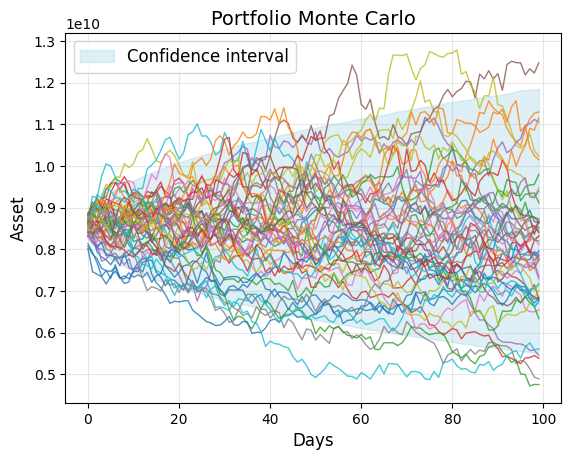

In [97]:
mean_simulation = portfolio_sims.mean(axis=1)
percentile_5 = np.percentile(portfolio_sims, 5, axis=1)
percentile_95 = np.percentile(portfolio_sims, 95, axis=1)

plt.fill_between(range(T), percentile_5, percentile_95, color="lightblue", alpha=0.4, label = "Confidence interval")

for i in range(50): 
    plt.plot(portfolio_sims[:, i], linewidth=1, alpha=0.8)

plt.title("Portfolio Monte Carlo", fontsize=14)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Asset", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [98]:
portfolio_values_day_10 = portfolio_sims[9, :]

ten_day_returns = (portfolio_values_day_10 / initialPortfolio - 1)

#10-day VaR
ten_day_var_95 = np.percentile(ten_day_returns, 5)


absolute_var = initialPortfolio * ten_day_var_95

ten_day_var_95, absolute_var

(-0.11994543690969718, -1027204621.0596195)

In [99]:
ten_day_var_99 = np.percentile(ten_day_returns, 1)
ten_day_var_99, ten_day_var_99*initialPortfolio

(-0.16291788739072313, -1395217784.7917101)

Показатели определенно поменялись, будем надеятся что в лучшуу сторону.

In [49]:
print(f"10-day HistVaR: {hist_var*np.sqrt(10)} or {hist_var*total_value*np.sqrt(10)}")

10-day HistVaR: -0.10937619995692492 or -936690389.6000648


В какой-то момент, я оссознал, что GOTU (в прошлом GTX) IPO проводил в 2019-06-06 (до того портфель расчитывал с февраля 19ого). Теперь после пересчета стало всё ещё хуже по VaR))

- прошлые значения: 10-day HistVaR: -0.10110477303831131 or -865848350.1559699
- новые: -0.10937687759227527 or -936689595.9758221

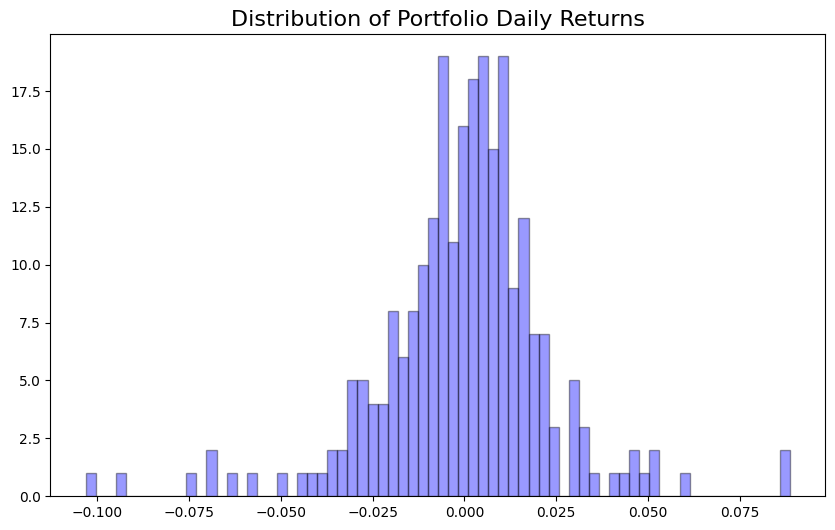

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(daily_returns @ weights, bins=0, color='blue', alpha=0.4, edgecolor='black')
# plt.axvline(hist_var, color='red', linestyle='--', linewidth=2, label=f'VaR (5%): {hist_var:.4f}')
# plt.text(hist_var, plt.gca().get_ylim()[1] * .2, f'VaR: {hist_var:.4f}', color='red', fontsize=10, ha='right')

# plt.axvline(hist_cvar, color='orange', linestyle='--', linewidth=2, label=f'CVaR: {hist_cvar:.4f}')
# plt.text(hist_cvar, plt.gca().get_ylim()[1] * 0.6, f'CVaR/ES: \n{hist_cvar:.4f}', color='orange', fontsize=10, ha='right')

plt.title("Distribution of Portfolio Daily Returns", fontsize=16)
# plt.xlabel("Portfolio Daily Returns (%)", fontsize=12)
# plt.ylabel("Frequency", fontsize=12)

plt.show()

UPD: надо переписать эту часть - стало хуже всё чутка по VaR)

По посчитанному видим, что однодневный VaR по такой позиции - около 3%. 10-дневный более 10%. Что кажется достаточно серьезной потерей. Хотя у нас есть 1,5 млрд кэша, в то время как абсолютное значение 10-дневного VaR (в деньгах) около 865 млн. Рисковано? Кажется что да.

Хочется понять насколько относително чего-то понятного. Например посмотрим на коэфиент Шарпа.

Посчитаем его для нашего портфеля, и для индексов NASDAQ и S&P500

In [51]:
risk_free_rate_mean = 0.002 # mean of FRED rate in 2020, but in February it was 1%
risk_free_rate_feb = 0.01

In [52]:
def sharpe_ratio(weights, daily_returns, risk_free_rate):
    mean_daily_return = weights @ daily_returns.mean()
    annualized_return = mean_daily_return * 252

    port_volatility = np.sqrt(weights.T @ daily_returns.cov() @ weights)
    annualized_volatility = port_volatility * np.sqrt(252)

    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    return sharpe_ratio

Our Portfolio Sharpe Ratio: (feduary rate)

In [53]:
sharpe_ratio(weights, daily_returns, risk_free_rate_feb)

-0.23469151537150543

NASDAQ Ratio:

In [54]:
nasdaq_data = yf.download("^IXIC", start="2019-02-04", end="2020-02-04")['Adj Close']

nasdaq_daily_returns = np.log(nasdaq_data / nasdaq_data.shift(1)).dropna()

sharpe_ratio(np.array([1.0]), nasdaq_daily_returns, risk_free_rate_feb)

[*********************100%***********************]  1 of 1 completed


1.531487732181236

S&P500 Ratio:

In [55]:
sp500_data = yf.download("^GSPC", start="2019-02-04", end="2020-02-04")['Adj Close']

sp500_daily_returns = np.log(sp500_data / sp500_data.shift(1)).dropna()

sharpe_ratio(np.array([1.0]), sp500_daily_returns, risk_free_rate_feb)

[*********************100%***********************]  1 of 1 completed


1.4115179544436574

The same with real mean of FRED rate in 2020:

In [56]:
sharpe_ratio(weights, daily_returns, risk_free_rate_mean)

-0.21311517782700498

In [57]:
sharpe_ratio(np.array([1.0]), nasdaq_daily_returns, risk_free_rate_mean)

1.5862541392862175

In [58]:
sharpe_ratio(np.array([1.0]), sp500_daily_returns, risk_free_rate_mean)

1.4792968501384338

Nothing changes for us.

Let's change cash to treasures indexes for incerease portfolio volatility and rise liquidity with returns

Choices of bonds ETF:
- [iShares Core U.S. Aggregate Bond ETF (AGG)](https://finance.yahoo.com/quote/AGG/) -- exposure to investment-grade bonds, including U.S. Treasuries, corporate bonds, mortgage-backed securities, and more. It provides diversification, moderate risk, and stable income, making it suitable for conservative portfolios.
- [iShares U.S. Treasury Bond ETF (GOVT)](https://finance.yahoo.com/quote/GOVT/) -- tracks the ICE U.S. Treasury Core Bond Index, offering exposure exclusively to U.S. Treasury bonds across various maturities.

First for $\frac{2}{3}$ of cash position and remaining for second ETF 

In [103]:
tickers = ['PARA',
            "WBD",
            "GOTU",
            "IQ",
            "TME",
            "VIPS",
            "BIDU",
            "FTCHQ", 
            "TCBI",
            
            # bonds ETF
            "AGG",
            "GOVT",
            ]

In [104]:
initial_value = 10_000_000_000

In [105]:
weights = df["Portfolio Value (5%)"] / initial_value
weights = np.array(weights.to_list())
new_weights = np.append(weights,  [0.1, 1-(weights.sum()+0.1)])

weights, new_weights

(array([0.08980549, 0.35754951, 0.04457221, 0.0626326 , 0.05448953,
        0.02740197, 0.18598415, 0.02131515, 0.01264263]),
 array([0.08980549, 0.35754951, 0.04457221, 0.0626326 , 0.05448953,
        0.02740197, 0.18598415, 0.02131515, 0.01264263, 0.1       ,
        0.04360675]))

In [106]:
data = yf.download(tickers, start='2019-06-06', end='2020-06-05')['Adj Close']
data

[*********************100%***********************]  11 of 11 completed


Ticker,AGG,BIDU,FTCHQ,GOTU,GOVT,IQ,PARA,TCBI,TME,VIPS,WBD
Date,,,,,,,,,,,
2019-06-06,94.933296,108.889999,19.780001,10.480000,22.760643,17.910000,41.667320,59.860001,13.080791,6.837951,28.379999
2019-06-07,95.200279,109.809998,19.760000,10.000000,22.822880,17.879999,41.805462,58.709999,13.487088,7.052551,28.420000
2019-06-10,94.950508,111.760002,19.650000,9.550000,22.760643,18.190001,41.416931,59.310001,14.170856,7.315925,28.250000
2019-06-11,94.933296,115.370003,21.000000,9.520000,22.742857,18.309999,41.511902,59.500000,14.051941,7.550034,28.969999
2019-06-12,95.053856,113.089996,21.080000,9.570000,22.778427,18.219999,41.727764,59.279999,13.952844,7.530525,29.230000
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-29,103.755753,106.550003,13.860000,31.360001,25.297901,16.590000,18.252352,26.760000,12.803320,16.914417,21.750000
2020-06-01,103.697418,107.099998,13.920000,32.610001,25.263512,16.700001,18.947599,28.330000,12.486210,16.719326,21.950001
2020-06-02,103.785797,107.230003,14.510000,36.970001,25.218271,17.200001,19.220419,28.680000,12.892507,17.187546,21.830000


In [107]:
data = data[tickers]
data

Ticker,PARA,WBD,GOTU,IQ,TME,VIPS,BIDU,FTCHQ,TCBI,AGG,GOVT
Date,,,,,,,,,,,
2019-06-06,41.667320,28.379999,10.480000,17.910000,13.080791,6.837951,108.889999,19.780001,59.860001,94.933296,22.760643
2019-06-07,41.805462,28.420000,10.000000,17.879999,13.487088,7.052551,109.809998,19.760000,58.709999,95.200279,22.822880
2019-06-10,41.416931,28.250000,9.550000,18.190001,14.170856,7.315925,111.760002,19.650000,59.310001,94.950508,22.760643
2019-06-11,41.511902,28.969999,9.520000,18.309999,14.051941,7.550034,115.370003,21.000000,59.500000,94.933296,22.742857
2019-06-12,41.727764,29.230000,9.570000,18.219999,13.952844,7.530525,113.089996,21.080000,59.279999,95.053856,22.778427
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-29,18.252352,21.750000,31.360001,16.590000,12.803320,16.914417,106.550003,13.860000,26.760000,103.755753,25.297901
2020-06-01,18.947599,21.950001,32.610001,16.700001,12.486210,16.719326,107.099998,13.920000,28.330000,103.697418,25.263512
2020-06-02,19.220419,21.830000,36.970001,17.200001,12.892507,17.187546,107.230003,14.510000,28.680000,103.785797,25.218271


In [108]:
daily_returns = np.log(data / data.shift(1)).dropna()
daily_returns

Ticker,PARA,WBD,GOTU,IQ,TME,VIPS,BIDU,FTCHQ,TCBI,AGG,GOVT
Date,,,,,,,,,,,
2019-06-07,0.003310,0.001408,-0.046884,-0.001676,0.030588,0.030901,0.008413,-0.001012,-0.019398,0.002808,0.002731
2019-06-10,-0.009337,-0.006000,-0.046044,0.017189,0.049455,0.036664,0.017602,-0.005582,0.010168,-0.002627,-0.002731
2019-06-11,0.002290,0.025167,-0.003146,0.006575,-0.008427,0.031499,0.031791,0.066445,0.003198,-0.000181,-0.000782
2019-06-12,0.005187,0.008935,0.005238,-0.004927,-0.007077,-0.002587,-0.019960,0.003802,-0.003704,0.001269,0.001563
2019-06-13,0.020480,0.022328,-0.001045,0.006019,0.012002,0.010309,0.008102,0.040442,0.002864,0.002172,0.001560
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-29,-0.021937,-0.010064,0.049348,0.050691,0.054885,0.094907,0.002161,0.047276,-0.042435,0.002638,0.002146
2020-06-01,0.037383,0.009153,0.039086,0.006609,-0.025080,-0.011601,0.005149,0.004320,0.057013,-0.000562,-0.001360
2020-06-02,0.014296,-0.005482,0.125488,0.029501,0.032021,0.027620,0.001213,0.041511,0.012279,0.000852,-0.001792


95%

In [114]:
hist_var = historical_var(daily_returns, new_weights, 0.95)
hist_var*np.sqrt(10), hist_var*initial_value*np.sqrt(10)

(-0.09279963196719795, -927996319.6719795)

In [115]:
hist_cvar = historical_Cvar(daily_returns, new_weights, 0.95)
hist_cvar*np.sqrt(10), hist_cvar*initial_value*np.sqrt(10)

(-0.1628671259854995, -1628671259.854995)

99%

In [116]:
hist_var = historical_var(daily_returns, new_weights, 0.99)
hist_var*np.sqrt(10), hist_var*initial_value*np.sqrt(10)

(-0.2009926499759175, -2009926499.7591748)

In [117]:
hist_cvar = historical_Cvar(daily_returns, new_weights, 0.99)
hist_cvar*np.sqrt(10), hist_cvar*initial_value*np.sqrt(10)

(-0.25136273844194, -2513627384.4193997)

In [118]:
sharpe_ratio(new_weights, daily_returns, risk_free_rate_mean)

-0.17461781638768897

Ситуацию это не спасло...$1,5$ млдр bonds ETF конечно делают лучше, но видимо не настолько.